In [1]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
import random

from utils.data_loaders import get_wake_datasets
from utils.evaluation import test_sklearn_model
import utils.plotting as plotting

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
MAX_DEPTH = None

MODEL_NAME = f"univariate_DT_max-depth{MAX_DEPTH}_{train_reduc_factor_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
print(MODEL_NAME)

training_factors=ti4-ct4
univariate_DT_max-depthNone_training_factors=ti4-ct4


In [3]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(DATA_FOLDER,
                                                               consider_ws=CONSIDER_WS,
                                                               coords_as_input=COORDS_AS_INPUT,
                                                               #train_perc=0.6,
                                                               #validation_perc=0.2,
                                                               #test_perc=0.2
                                                               input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                               )

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

grid_size = train_dataset.num_cells
print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:245: UserWarning: Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


Train shapes:  torch.Size([3942400, 4]) torch.Size([3942400, 1])
grid_size=7168


In [4]:
train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)
train_size = train_x.shape[0]

test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_size = test_x.shape[0]

valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
print("Valid shapes: ", valid_x.shape, valid_y.shape)
valid_size = valid_x.shape[0]

size = train_size + test_size + valid_size
print(train_size/size, test_size/size, valid_size/size)

Train shapes:  torch.Size([3942400, 4]) torch.Size([3942400, 1])
Test shapes:  torch.Size([28851200, 4]) torch.Size([28851200, 1])
Valid shapes:  torch.Size([28851200, 4]) torch.Size([28851200, 1])
0.06395348837209303 0.4680232558139535 0.4680232558139535


# Training

In [5]:
model = DecisionTreeRegressor(max_depth=MAX_DEPTH)
model.fit(train_x, train_y)
#tree_text = export_text(model)
#print(tree_text)

DecisionTreeRegressor()

In [6]:
importances = model.feature_importances_
for featurenum, importance in enumerate(importances):
    featurename = train_dataset.featurenum_to_featurename(featurenum)
    print(f"{featurename} feature importance={importance}")

ti feature importance=0.21651978373629718
ct feature importance=0.20347379365592308
x/D feature importance=0.1472665152659534
y/D feature importance=0.4327399073418263


In [7]:
model_description=MODEL_NAME+"_"+FACTORS_FOLDER
     #TODO "new splitting technique excluding a range of TIs and CTs -> trained only in range (0, 0.56/58) and tested only in range (0.78/0.8, 0.94/0.96)"

test_sklearn_model(model, test_x, test_y,
                   model_description=model_description,
                   save_results=True)

Test results for univariate_DT_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.9936270909480339
explained_variance_score=0.9936359912618545
mean_squared_error=7.146157344630566e-06
mean_absolute_error=0.0009495010753930356
median_absolute_error=0.00034946357482112944
mean_absolute_percentage_error=0.08077043292249024
Prediction time=1.2803477331824078e-07s


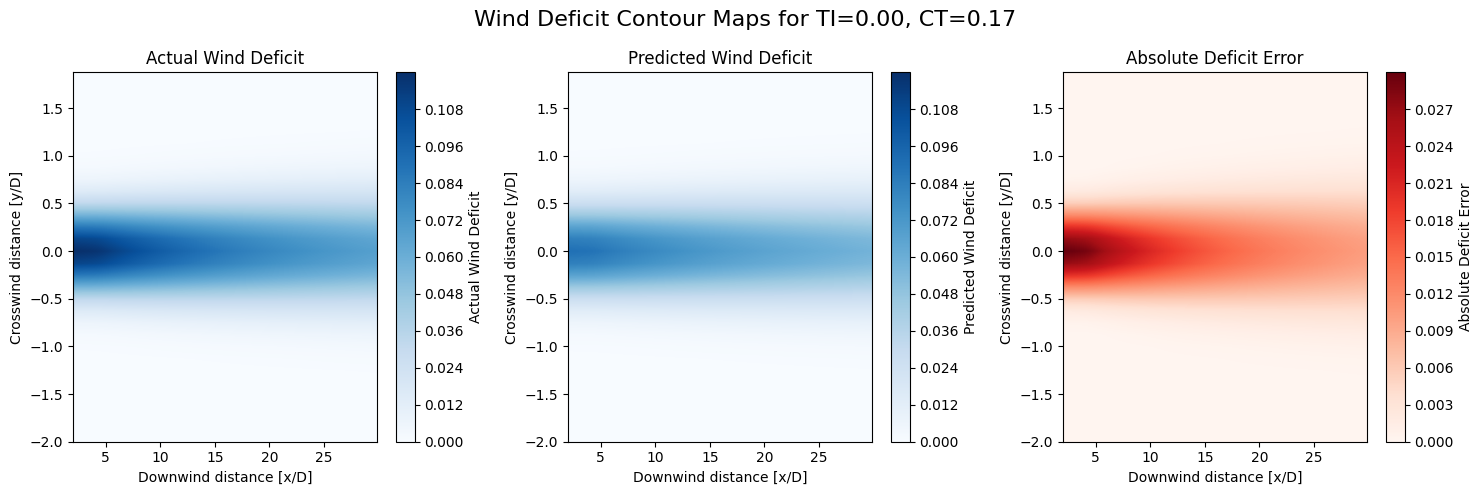

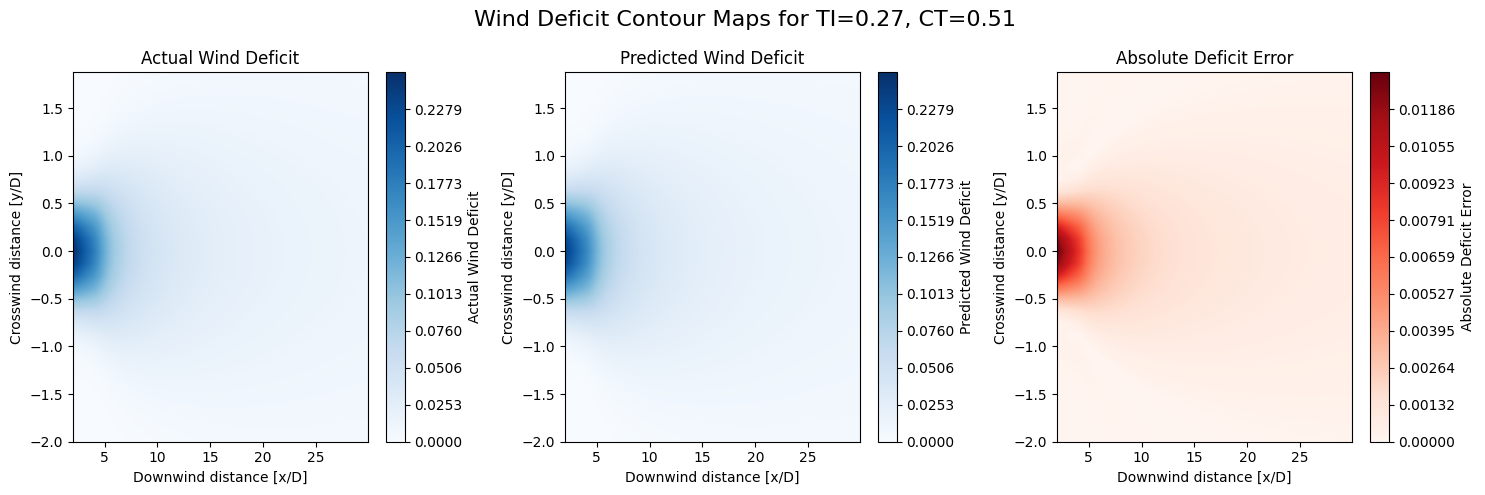

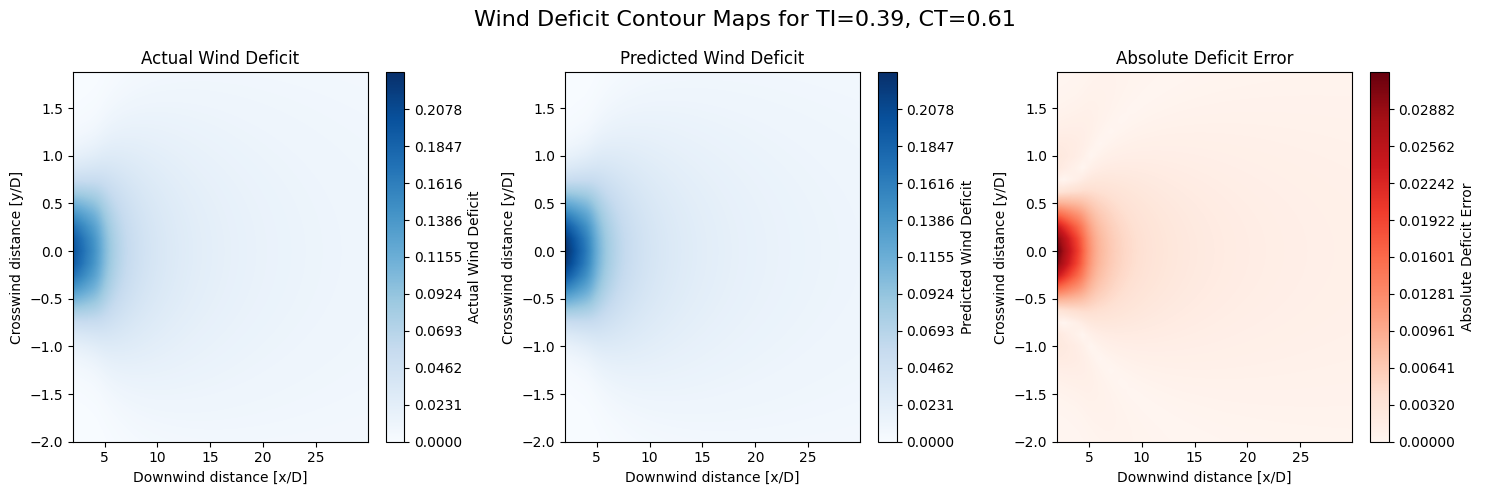

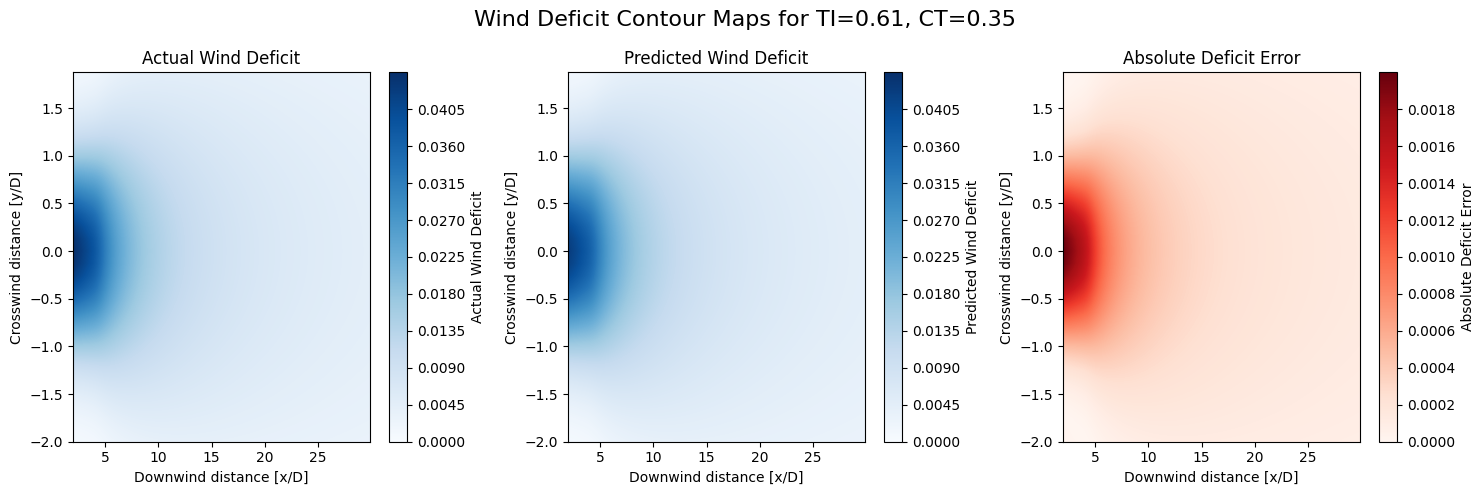

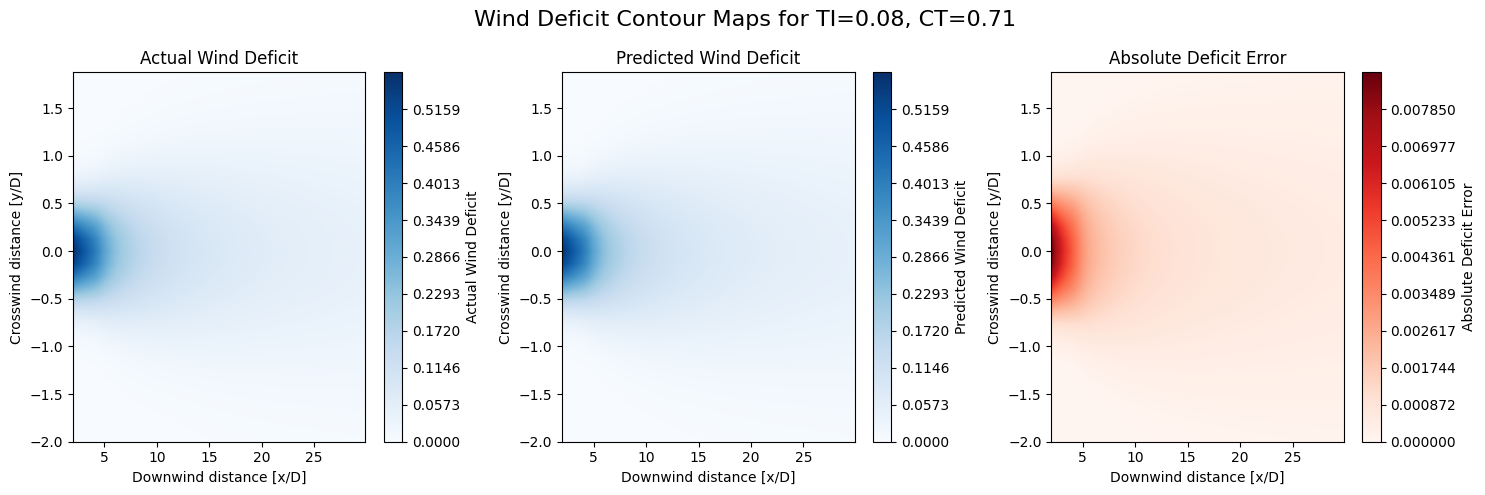

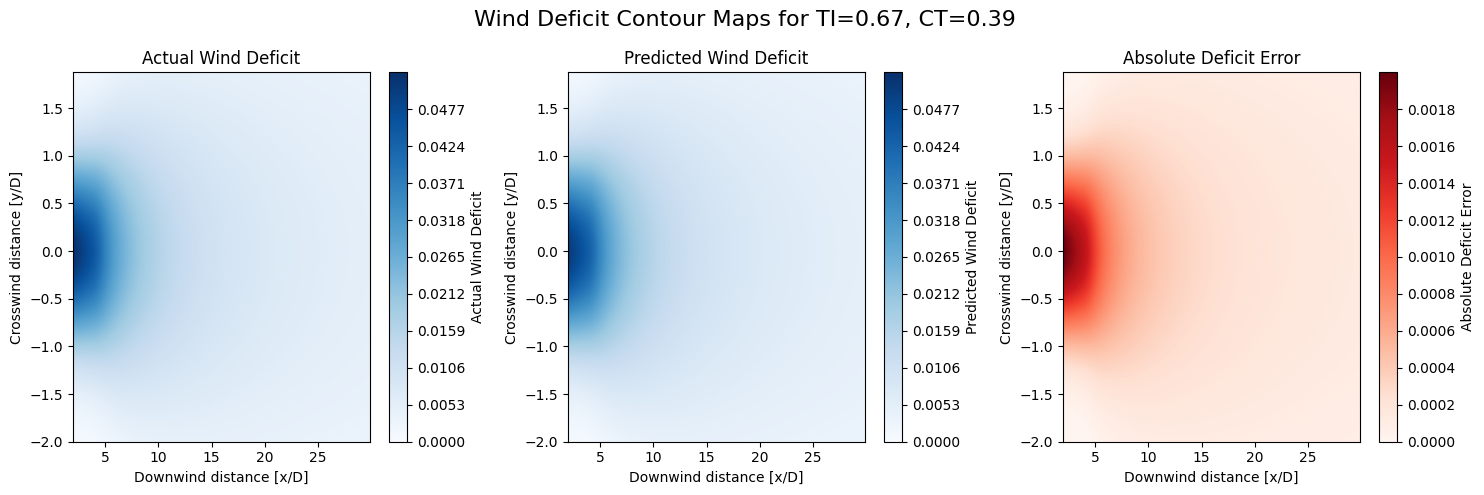

KeyboardInterrupt: 

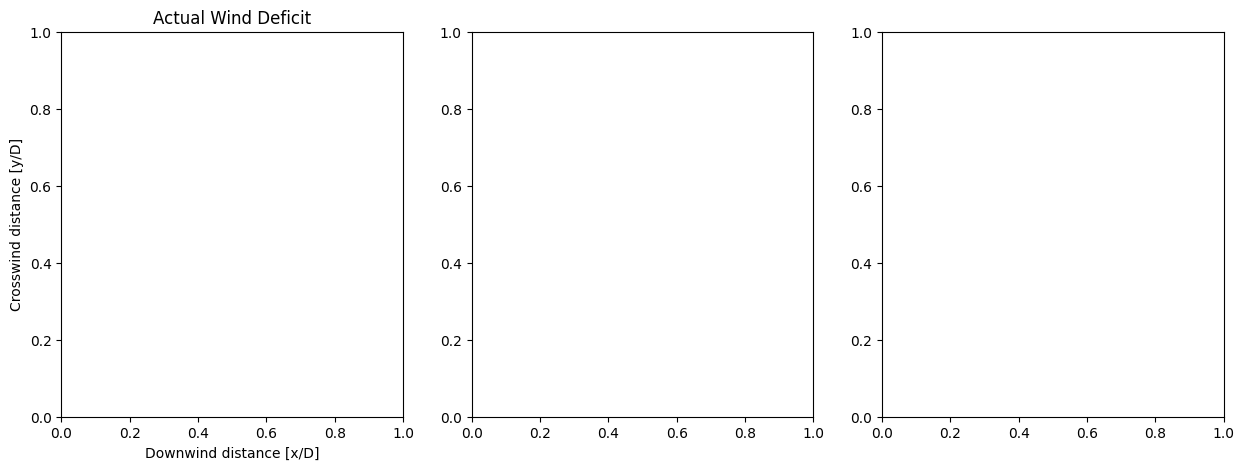

In [9]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

for idx in field_indices:
    ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, idx)
    
    plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')